# Photon-to-axion/dark-photon coupling solver in the case of costant magnetic field and increasing-decreasing $n_e(z)$

(SEE THE GENERAL NOTEBOOK FOR A MORE PRECISE TREATMENT OF THE MATTER)

Here we want to solve the photon-to-axion or the photon-to-dark_photon conversion equation in the case of an increasing and then decreasing $n_e(z)$. In this case the resonance points are two, and the code is generalized by varying the distance between the two resonance points.

We impose the resonance points are at $z_{shift}$ and at a certain value $2 \bar{z}+z_{shift}$. The increasing-decreasing pattern is symmetric, therfore the peak of $n_e(z)$ is in $\bar{z}+z_{shift}$. We generalize the defined function in terms of this $\bar{z}$. 

At the beginning of the code you are able to choose if you want to work in the case of photon-to-axion or photon-to-dark-photon.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint, solve_ivp, ode
from scipy.stats import norm
from scipy.interpolate import CubicSpline, interp1d
from scipy.integrate import quad
import math


#OdeintW - wrapper to solve ODE with complex terms.
import odeintw 
from odeintw import odeintw


# Visual settings
%config InlineBackend.figure_format='retina'
%matplotlib inline

if '/Library/TeX/texbin/' not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
    
# Latex font
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import colors
plt.rcParams['figure.figsize'] = [9,7]  # Adjust the size as needed for the plots
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Want to study photon-to-axion or photon-to-dark-photon?

dark_photon = False #Set False if you want to work with axion

In [3]:
####################################
# Natural unit conversions
####################################

#We express all the quantities in eV
GeV = 1 
MeV = 1e-3
keV = 1e-6
eV  = 1e-9
meV = 1e-12 

#Units:
Kg     = 5.609 * 1e35 * eV
meter  = 5.07 * 1e6 * eV**-1
cm     = 1e-2 * meter
Km     = 1e3 * meter
Mpc    = 1.564 * 1e29 * eV**-1
second = 1.5192 * 1e15 * eV**-1
Hz     = 1/second


Gauss  = 1.95 * 1e-2 * eV**2
Joule  = 6.242 * 1e18 * eV  

#Constants
AlphaEM           = 1/137
H_0               = 67.66 * Km/second / Mpc
ElementaryCharge  = np.sqrt(4 * np.pi * AlphaEM);
mass_electron     = 9.109 * 1e-31 * Kg
mass_proton       = 1.672 * 1e-27 * Kg
numerical_density = 1/cm**3


In [4]:
########################################
# Interval of integration
########################################


zmin  = -1  #Here we work in units of Delta_ag Mpc, i.e. with \tilde{z} = Delta_{ag} z = Delta_{ag} Mpc z_adimensional
zmax  = 1

z_num = 5000001
z_thr = np.linspace(zmin, zmax, z_num)  # Interval, in Delta_ag * Mpc. 


z_res =  z_clust =  z_thr[5000000] 

z_0 = z_thr[5000000]    #Just a pivotal scale. Try to always set it to 1 (Delta_ag Mpc ) for convenience
z_0



1.0

In [5]:
########################################
# Specify parameters of the model
########################################

m_a   = 3e-13 * eV# Axion mass in eV
g_agg =  1e-10 * (GeV)**-1 #5e-11 * (GeV)**-1 # Axion photon-coupling in (GeV)^-1
nu    = 145 * 10**9 * Hz # Frequency in Hz 
omega = 2.*np.pi*nu # Angular frequency in Hz

if dark_photon:
    eps   = 1e-5 #photon-dark photon coupling “natural” values in the range 1e-13 - 10e-2 eV 



In [6]:
########################################
# Specify functions of the model in the case of constant magnetic field and linear electron numerical density
########################################

#Note: we decided to work with \Delta_a and \Delta_\parallel defined without the minus sign. It is totally equivalent and the solution does not change.

def Delta_a(z):
    """
    Axion mass term
    Delta_a = -m_a^2/(2*omega)
    """
    return m_a**2/(2*omega) 

z_shift=0.1 #It is the value at which the first resonance happens
def n_e(z,z_bar):
    """
    Function that grows linearly up to a point z_bar, and then
    symmetrically decreases
    """
    z = np.asarray(z)
    result = np.zeros_like(z) 

    C = (m_a**2 * mass_electron) / (ElementaryCharge**2)
    z_shifted = z-z_shift
    

    # Masks
    mask1 =  (z_shifted <= z_bar)  
    mask2 = (z_shifted > z_bar) 

    result[mask1] = C * (1 + z_shifted[mask1] / z_0)        
    result[mask2] = C * (1 + (2*z_bar - z_shifted[mask2]) / z_0)  
    
    result[result<0] =0
   

    return result.item() if np.isscalar(z) else result  


def m2_g(z,z_bar):
    """
    Effective mass of the photon
    acquired by scattering with free electrons
    """
    return   ElementaryCharge**2 * 1/mass_electron * n_e(z,z_bar) #in eV units 


def B_T(z):
    """
    Transverse magnetic field
    """
    return  1 * 1e-6 * Gauss  #in \mu G 


def Delta_parallel(z,z_bar):
    """
    Photon mass term
    Delta_parallel = -m^2_\gamma(z)/2\omega
    """
    return m2_g(z,z_bar) /(2* omega)


if dark_photon:
    def Delta_ag(z):
        return eps*Delta_a(z)
else:
    def Delta_ag(z):
        """
        Axion-photon coupling term
        Delta_{a\gamma} = g_{a\gamma\gamma}/2 B_T(z)
        """
        return g_agg/2 * B_T(z)


def Delta_osc(z,z_bar): 
    return np.sqrt((Delta_a(z) - Delta_parallel(z,z_bar))**2 + 4 * (Delta_ag(z))**2)

def delta_m2(z,z_bar):
    """
    Differences between Delta_\parallel and Delta_a
    """
    return ( m2_g(z,z_bar)-m_a**2)/(2*omega)

In [7]:
#Setting a value for z_bar
z_barr = 0.3

#Computing the index of z_bar in the z_thr interval
index_z_barr = np.argmin(np.abs(z_thr - z_barr))
index_z_barr

#Computing the index of z_shift in the z_thr interval
index_z_shift = np.argmin(np.abs(z_thr - z_shift))
index_z_shift

2750000

In [8]:
#Computing the derivative of Delta_parallel and the factor gamma = Delta_ag(\tilde{z})/|dDelta_ag(\tilde z) / d\tilde{z}|

dDelta_parallel = np.abs(np.gradient(Delta_parallel(z_thr, z_barr), z_thr))

gamma_factor = (Delta_ag(z_thr))/(dDelta_parallel)
gamma_factor[index_z_shift]

/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_20992/3475671985.py:5: RuntimeWarning: divide by zero encountered in divide
  gamma_factor = (Delta_ag(z_thr))/(dDelta_parallel)


1.2993466199436547e-05

In [9]:
# Computing gamma by hand to check if the derivation went well: 

#With our n_e(z) parametrization we have gamma =  \Delta_{a\gamma}z_0/\Delta_{a} 

gamma_factor_direct = Delta_ag(z_thr)/Delta_a(z_thr) *z_0
gamma_factor_direct

1.2993466192769797e-05

In [10]:
#Computing the probability à la C. Mondino, and comparing it with 2\pi\gamma

log = np.log(m2_g(z_thr, z_bar=z_barr))
derivative = np.abs(np.gradient(log, z_thr))**-1

if dark_photon:
    prob_Mondino  = (np.pi * eps**2 * m_a**2/omega ) * derivative[index_z_shift] /Delta_ag(z_thr) #Here the resonance happens at z_shift, then you need the index of it
else:
    prob_Mondino  = omega * np.pi * g_agg**2 * B_T(z_clust)**2 / m_a**2 * derivative[index_z_shift] /Delta_ag(z_thr) #Here the resonance happens at z_shift, then you need the index of it

print("2*pi*gamma is",  2*np.pi*gamma_factor[index_z_barr])
print("Mondino's probability is",  prob_Mondino)

2*pi*gamma is 8.16403559136343e-05
Mondino's probability is 8.164035587174585e-05


/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_20992/2794814484.py:3: RuntimeWarning: divide by zero encountered in log
  log = np.log(m2_g(z_thr, z_bar=z_barr))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:1259: RuntimeWarning: invalid value encountered in scalar subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_20992/2794814484

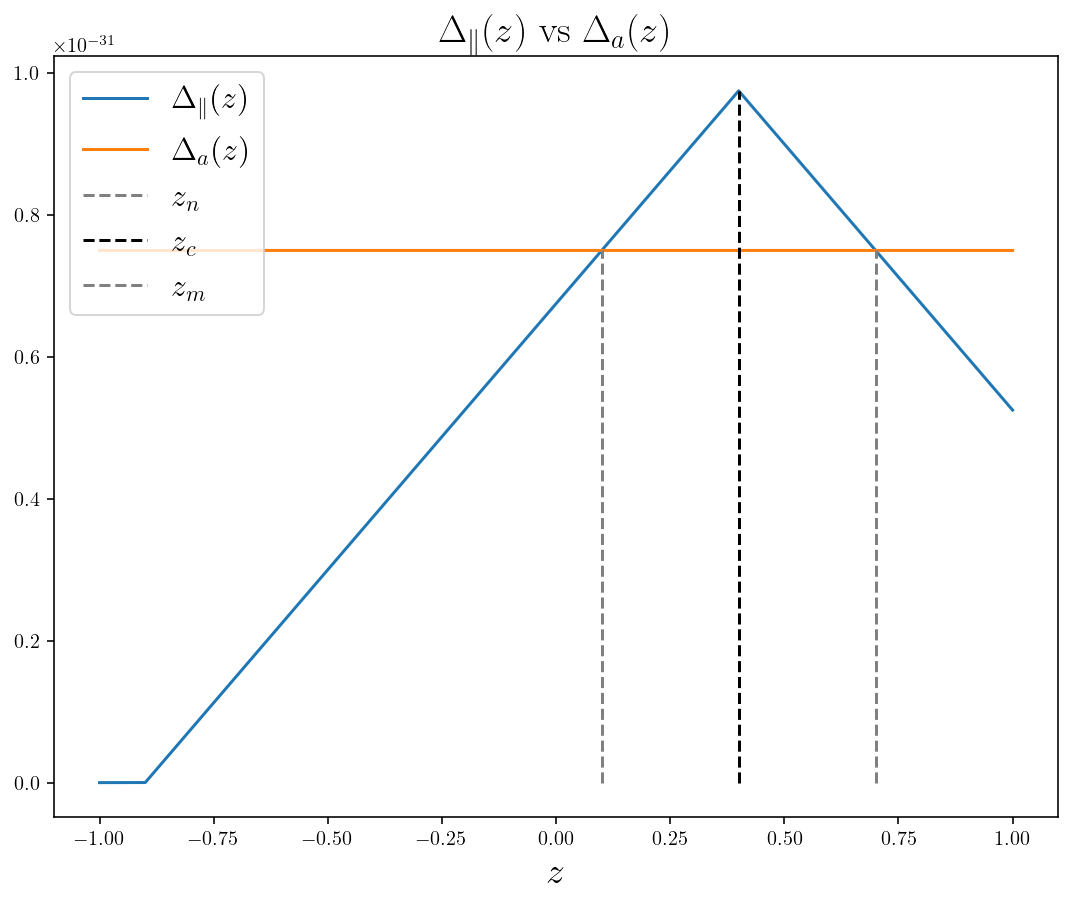

In [12]:
#Plotting Delta_parallel and Delta_a to check where resonance happens. 

plt.plot(z_thr, Delta_parallel(z_thr, z_bar=z_barr), label=r'$\Delta_\parallel(z)$')
plt.plot(z_thr, Delta_a(z_thr) * np.ones_like(z_thr), label=r'$\Delta_a(z)$')

z_n_line = plt.vlines(z_shift, 0, Delta_a(z_shift), linestyle='dashed', color='gray', label=r'$z_n$')
z_c_line = plt.vlines(z_shift + z_barr, 0, Delta_parallel(z_shift + z_barr, z_bar=z_barr), linestyle='dashed', color='black', label=r'$z_c$')
z_m_line = plt.vlines(2 * z_barr + z_shift, 0, Delta_a(2 * z_barr + z_shift), linestyle='dashed', color='gray', label=r'$z_m$')

plt.title(r'$\Delta_\parallel(z)$ vs $\Delta_a(z)$', fontsize=19)
plt.xlabel(r'$z$', fontsize=19)

plt.legend(fontsize=16, loc='upper left')

plt.show()

In [26]:
#Defining the solver for the photon-to-axion equation

def master_eq_LZ_1(z,S,z_bar): 
    """ Master equation """
    S = np.asarray(S, dtype=np.complex128)
    ax, f = S
    dSdz = [f, -1j * (Delta_parallel(z,z_bar) - Delta_a(z))/(Delta_ag(z)) * f  - ax]
    return np.array(dSdz, dtype=np.complex128)

#Initial values
z_init = z_thr[0]
ic_LZ = np.array([ 0, -1j ], dtype=np.complex128)

In [27]:
#Solving the for a spiecific value of z_bar

sol_LZ_1_increasing_decreasing =  solve_ivp( lambda z, S: master_eq_LZ_1(z, S, z_bar = z_barr), (z_thr[0], z_thr[-1]), ic_LZ, method='RK45', t_eval=z_thr, rtol=1e-10, atol=1e-12)


#Squaring to obtain the probability
p_LZ_1_increasing_decreasing =np.abs(sol_LZ_1_increasing_decreasing.y[0])**2 

In [28]:
#Computing the index of the second point of resonance. 
index_2z_bar = np.argmin(np.abs(z_thr - (2*z_barr+z_shift)))


#Averaging the probability from the second resonance point on, in order to obtain a mean value: 
P_mean_value_2nd_res = np.average(p_LZ_1_increasing_decreasing[index_2z_bar : ])
P_mean_value_2nd_res

0.0002617063580795271

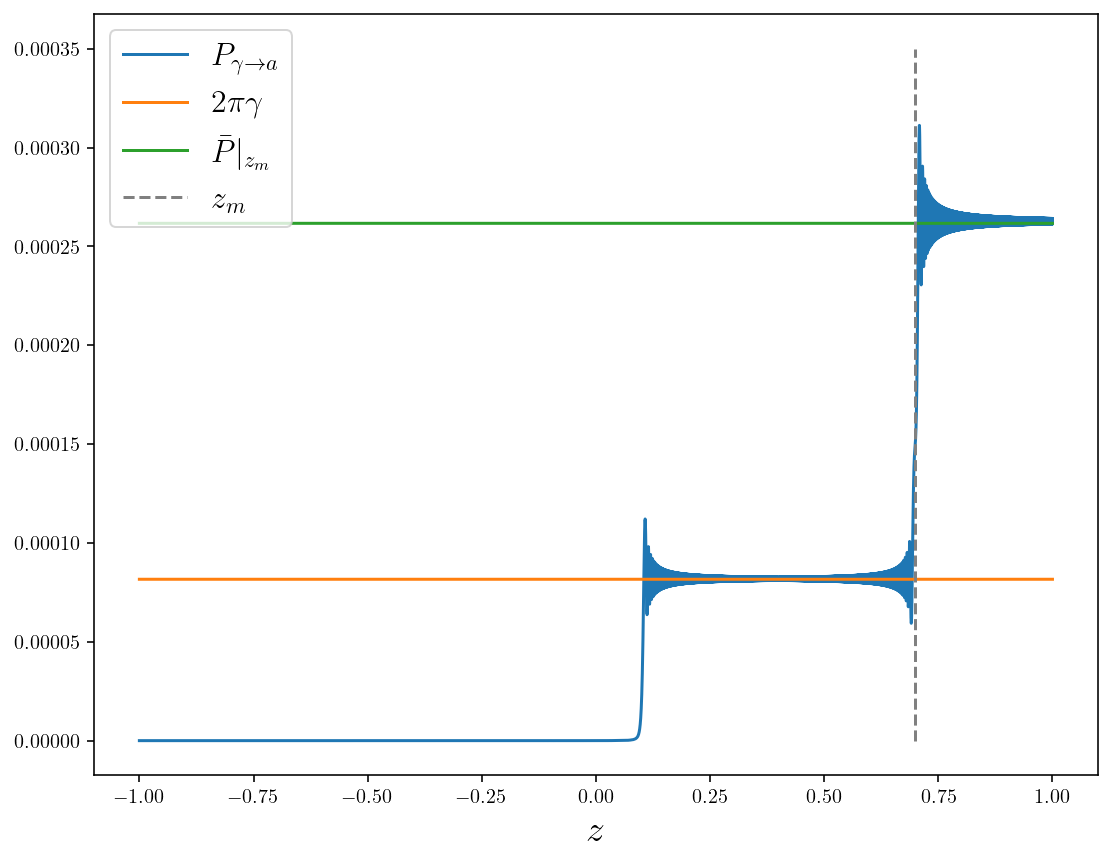

In [29]:
#Plotting the solution
plt.plot(z_thr, p_LZ_1_increasing_decreasing, label=r'$P_{\gamma \rightarrow a}$')
plt.plot(z_thr, 2*np.pi*gamma_factor[2500000]*np.ones_like(z_thr), label=r'$2\pi\gamma$')
plt.plot(z_thr,P_mean_value_2nd_res*np.ones_like(z_thr), label=r'$\bar{P}|_{z_m}$')
z_m_line = plt.vlines(2 * z_barr + z_shift, 0, 0.00035, linestyle='dashed', color='gray', label=r'$z_m$')
plt.xlabel(r'$z$', fontsize=19)
plt.legend(fontsize=16, loc='upper left')

For multiple resonance cases there are Quantum Mechanics effect of interference between the waves. In the paper by Brahma et al. (https://arxiv.org/abs/2308.08586) these phase effects are studied. 
The proposed equation for multiple level crossing is

$ P_{\gamma \mapsto a} = \sum_n (2\pi \gamma_n) + 2 \sum_{n<m} \sqrt{(2\pi\gamma_n) (2\pi \gamma_m) } \cos{\Phi_{nm}} $, 

where $\Phi_{nm}$ is a certain phase: 

$\Phi_{nm} = \Phi(z_n) - \Phi(z_m) +\frac{\pi}{4} (\sigma_n-\sigma_m)$

where $\Phi(z)$ is defined to be

$\Phi(z) = \int_{z_i}^{z} (\Delta_\parallel(z) - \Delta_a) dz = \int_{\tilde{z}_i}^{\tilde{z}} d\tilde{z}'_A \, \frac{\Delta_\parallel(\tilde{z}') - \Delta_a}{\Delta_{a\gamma}}$

and

$\sigma(z) = \text{sign}\left[\Phi''(z)\right] = \text{sign}\left[\Delta'_\parallel(z)\right]$.

For two resonance points and in our case of linear increasing-decreasing we have

$\Phi_{nm} = \int_{z_m}^{z_n} \ (\Delta_\parallel(z) -\Delta_a) dz -\frac{\pi}{2} = \frac{1}{2} 2\bar{z} \frac{\Delta_a}{z_0} \bar{z} -\frac{\pi}{2}$.

From the probability equation, being $\cos{\Phi_{nm}}$ maximum in 1, minumum in -1 and on average 0 we get that, in our case of two resonance points ($n=1,2$) where $\gamma_n = \gamma_m$: 

1) Maximum at: $2\pi\gamma (1+1+2) = 4 (2\pi\gamma)$

2) Mean at: $2\pi\gamma (1+1+0) = 2 (2\pi\gamma)$

3) Minum at: $2\pi\gamma (1+1-2) = 0$


In [30]:
# Computing Phi_nm: 

#Defining the interval of integration:
z1 = +z_shift
z2 = 2*z_barr+z_shift  


integral, error = quad(delta_m2, z2, z1, args=(z_barr,)) # Integrating Delta_\parallel - Delta_a
area = (-1)/(Delta_ag(z_barr)) * integral #Renormalized integral by 1/Delta_ag(z_barr), being solving in tilde{z}.

print(f"Area = {area}, enstimated error: {error}")

# Check if the integral is correct

#Area = 0.5 x basis x high
basis = 2*z_barr
high = Delta_parallel(z_barr+z_shift, z_barr) - Delta_a(z_barr)
area_triangle = 0.5 * basis*high /(Delta_ag(z_barr))
print('Area triangle = ', area_triangle)

#With our parametrization of n_e(z) we have
area_explicit = Delta_a(z_barr)/z_0 * z_barr *(z_barr) /(Delta_ag(z_barr))
print('Area explicit = ', area_explicit)


phi_nm = area - np.pi/2 #this is \Phi_nm
factor = 1+1+2*np.cos(phi_nm) #P = 2\pi\gamma x factor
print('Probability factor = ', factor)
print('Area/2pi = ', area/(2*np.pi))


Area = 6926.558215088176, enstimated error: 7.526505423619623e-47
Area triangle =  6926.558215088169
Area explicit =  6926.558215088166
Probability factor =  3.216074652681699
Area/2pi =  1102.3959785450588


In [31]:
#From the probability at the second resonance point we can compute the numerical \Phi_nm and the numerical factor 

numerical_phase = np.arccos( (P_mean_value_2nd_res - 4*np.pi*gamma_factor[index_z_shift])/(4*np.pi*gamma_factor[index_z_shift]) )
numerical_factor = 1+1+2*np.cos(numerical_phase)
print('Numerical prob factor = ', numerical_factor)

Numerical prob factor =  3.2056004062057375


In [32]:
error_2nd_prob = np.abs((numerical_factor-factor)/factor)
print('Error num vs ana = ', error_2nd_prob)


Error num vs ana =  0.0032568418358160382


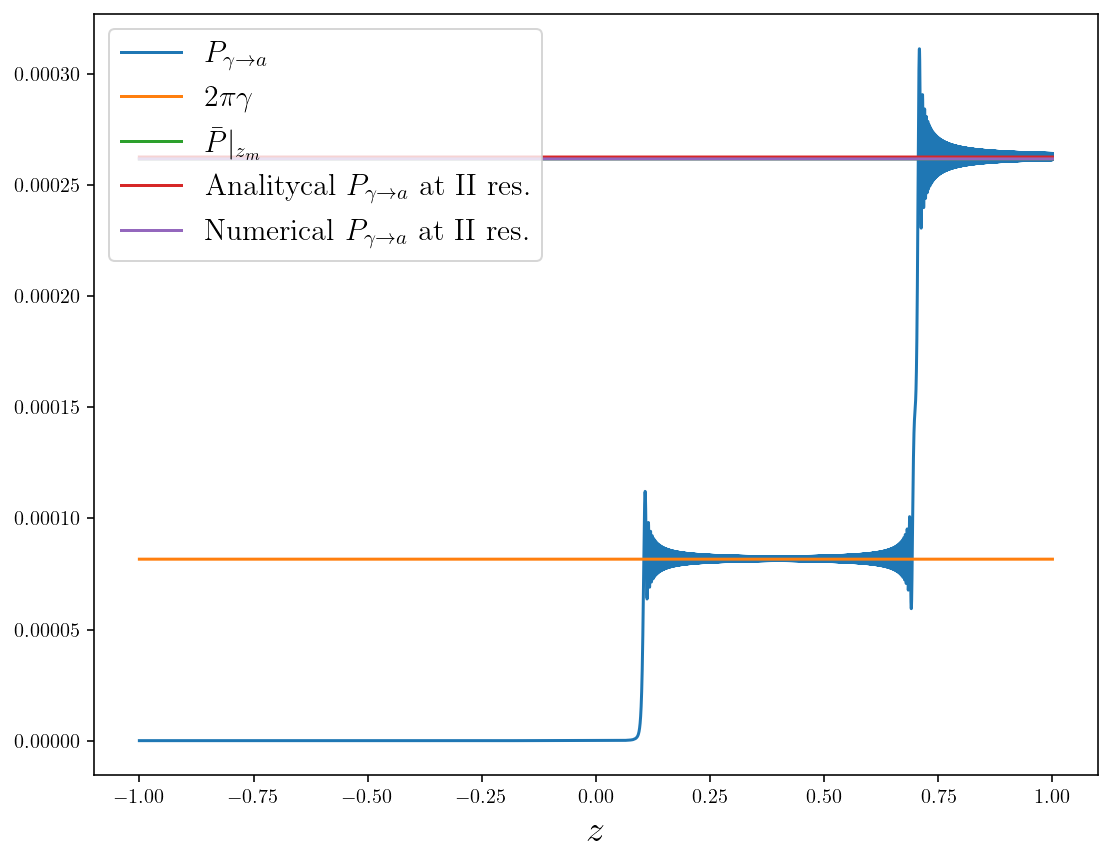

In [33]:
#Plotting the solution
plt.plot(z_thr, p_LZ_1_increasing_decreasing, label=r'$P_{\gamma \rightarrow a}$')
plt.plot(z_thr, 2*np.pi*gamma_factor[index_z_shift]*np.ones_like(z_thr), label=r'$2\pi\gamma$')
plt.plot(z_thr,P_mean_value_2nd_res*np.ones_like(z_thr), label=r'$\bar{P}|_{z_m}$')
plt.plot(z_thr,2*np.pi*gamma_factor[index_z_shift]*np.ones_like(z_thr) * factor, label=r'Analitycal $P_{\gamma \rightarrow a}$ at II res.') #Analytical probability at the second resonance point
plt.plot(z_thr,2*np.pi*gamma_factor[index_z_shift]*np.ones_like(z_thr) * numerical_factor, label=r'Numerical $P_{\gamma \rightarrow a}$ at II res.') #Numerical probability at the second resonance point

plt.xlabel(r'$z$', fontsize=19)
plt.legend(fontsize=15, loc='upper left')


In [57]:
#Oscillation and resonance lenghts

#Oscillation lenght

z_test = z_thr[3500000]
losc_tilde = 2*np.pi/ ( (Delta_parallel(z_test,z_bar=z_barr) - Delta_a(z_test) )/(Delta_ag(z_test)) )
print('losc is', losc_tilde)


#Resonance lenght
R_lenght = np.sqrt( 2*np.pi*gamma_factor[index_z_shift])/Delta_ag(z_thr[index_z_shift])
R_lenght_tilde =  np.sqrt( 2*np.pi*gamma_factor[index_z_shift])
print('R_lenght is', R_lenght_tilde)

Oscillation lenght at resonance 3.2221463113741467e+36
Oscillation lenght in vacuum 8.373369832999575e+31
losc is 0.00027213451957248616
R_lenght is 0.009035505293763835


(5e-05, 0.0001)

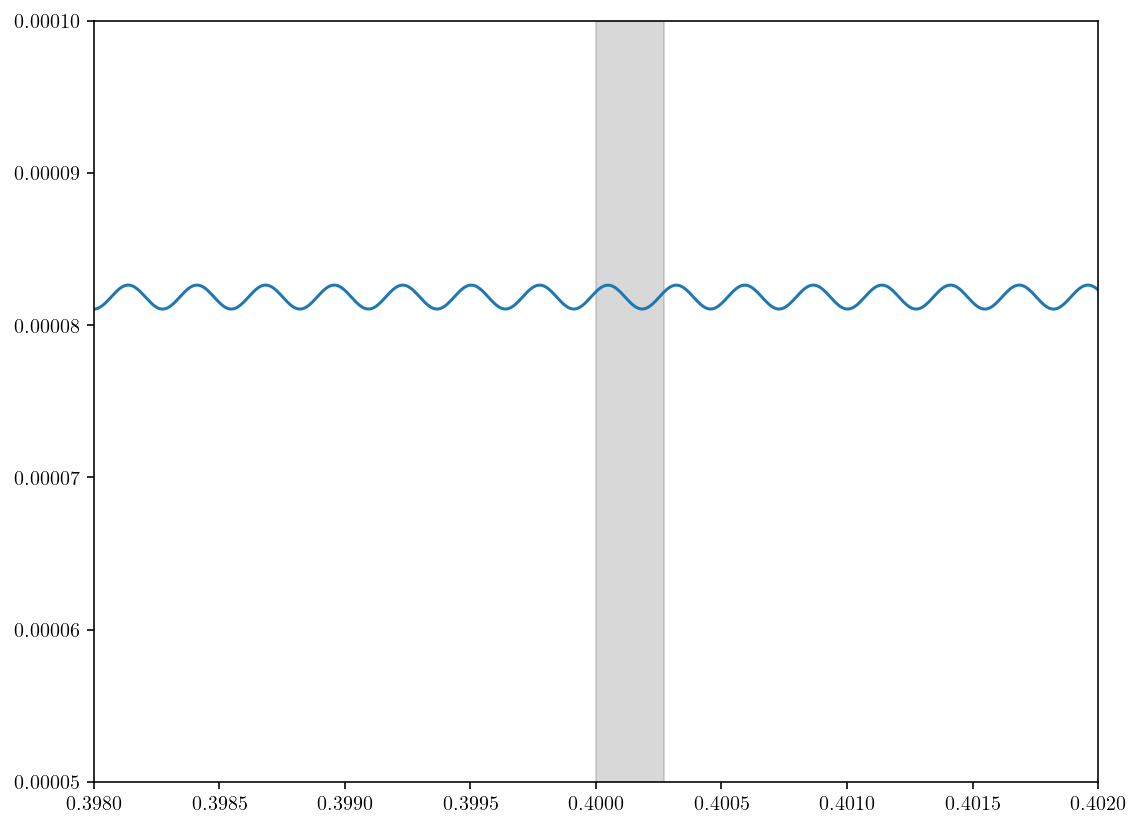

In [53]:
plt.plot(z_thr, p_LZ_1_increasing_decreasing)
plt.axvspan(z_test , z_test+ losc_tilde, color='gray', alpha=0.3) 
plt.xlim(z_test-0.002 ,z_test+0.002)
plt.ylim(0.00005, 0.0001)


(-0.1, 0.30000000000000004)

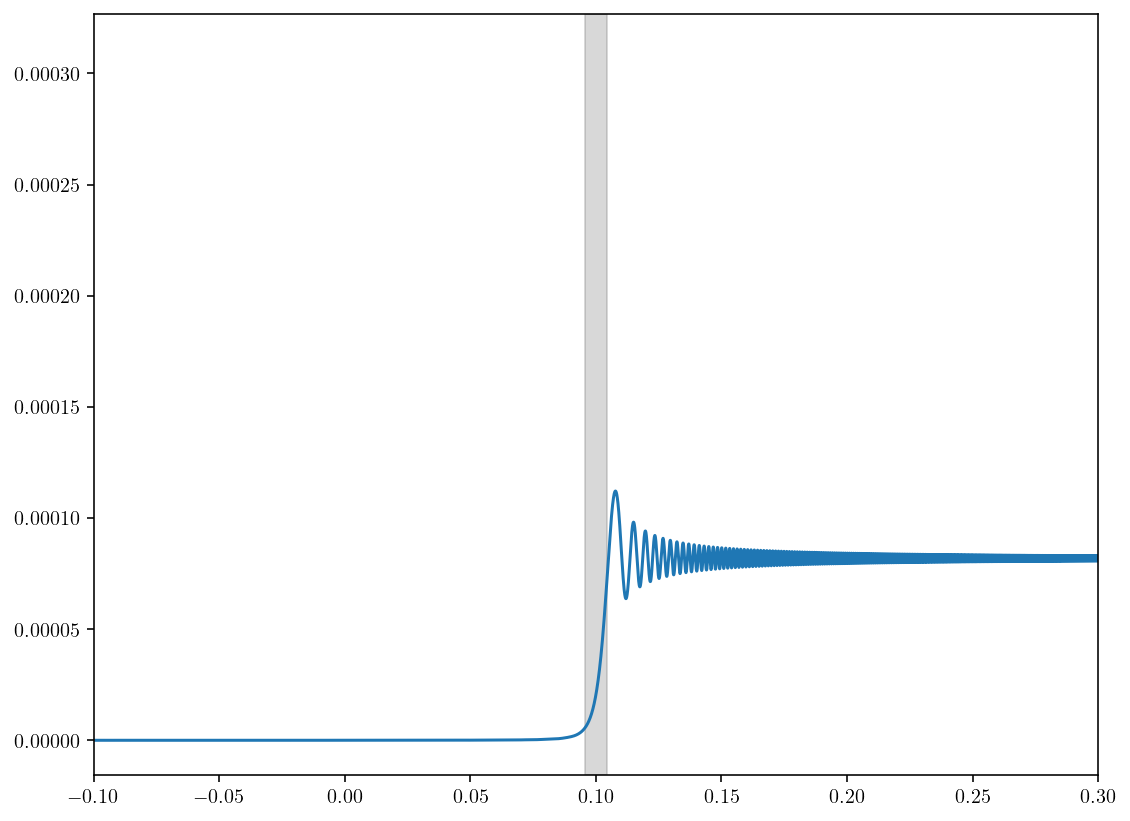

In [61]:
plt.plot(z_thr,p_LZ_1_increasing_decreasing)
plt.axvspan( (z_shift - R_lenght_tilde/2).item(), (z_shift + R_lenght_tilde/2).item(), color='gray', alpha=0.3) 
plt.xlim(z_shift-0.2 ,z_shift+0.2)

# Solving for multiple values of z_bar

Hereafter we want to solve for multiple values of z_bar, e.g. for 4000 values. This takes lot of time and needs to be runned on an HPC. We did it for a big value of gamma ($\gamma \simeq 0.02$) in order to have a faster code. 

According to theory (see above), by plotting the (averaged) probability at the secondo point of resonance values obtained for a certain z_bar vs. z_bar itself, we should observe:
1) Maximum at: $2\pi\gamma (1+1+2) = 4 (2\pi\gamma)$

2) Mean at: $2\pi\gamma (1+1+0) = 2 (2\pi\gamma)$

3) Minum at: $2\pi\gamma (1+1-2) = 0$

Moreover, for very small values of z_barr, meaning small distance between the two resonance points, we should observe a breakdown of the LZ approximation. 

In [129]:
#In the case the couples have already been computed and saved:
couples1 = np.loadtxt('couples1.txt')
couples2 = np.loadtxt('couples2.txt')
couples3 = np.loadtxt('couples3.txt')

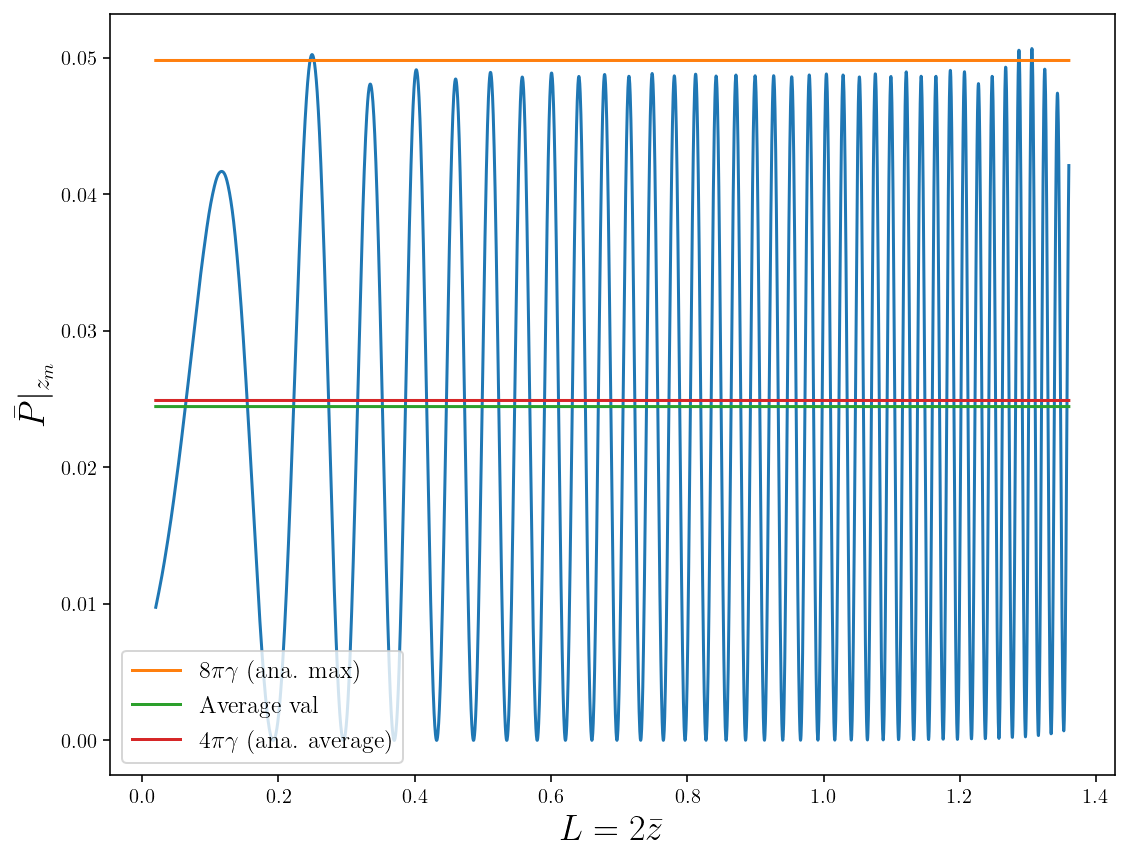

In [130]:
#Here we plot the average probability after the second point of resonance vs the distance L = 2z_bar between the two resonance points. 

average_P_mean_value_2nd_res = np.average(couples3[:,1]) #Computing the mean

# Plot the probability vs. distance L = 2z_bar
plt.plot(couples3[:,0], couples3[:,1])  
plt.plot(couples3[:,0], 4*2*np.pi*gamma_factor[index_z_barr]*np.ones_like(couples3[:,0]), label=r'$8\pi\gamma$ (ana. max)')  
plt.plot(couples3[:,0], average_P_mean_value_2nd_res*np.ones_like(couples3[:,0]), label="Average val")  
plt.plot(couples3[:,0], 2*(2*np.pi)*(gamma_factor[index_z_barr]) * np.ones_like(couples3[:,0]), label=r'$4\pi\gamma$ (ana. average)')  

plt.xlabel(r'$L = 2\bar{z}$', fontsize=18)
plt.ylabel(r'$\bar{P}|_{z_m}$', fontsize=18)

# Set x-axis limits
#plt.xlim(0.3, 0.4)

plt.legend(fontsize=12, loc='lower left')
plt.show()


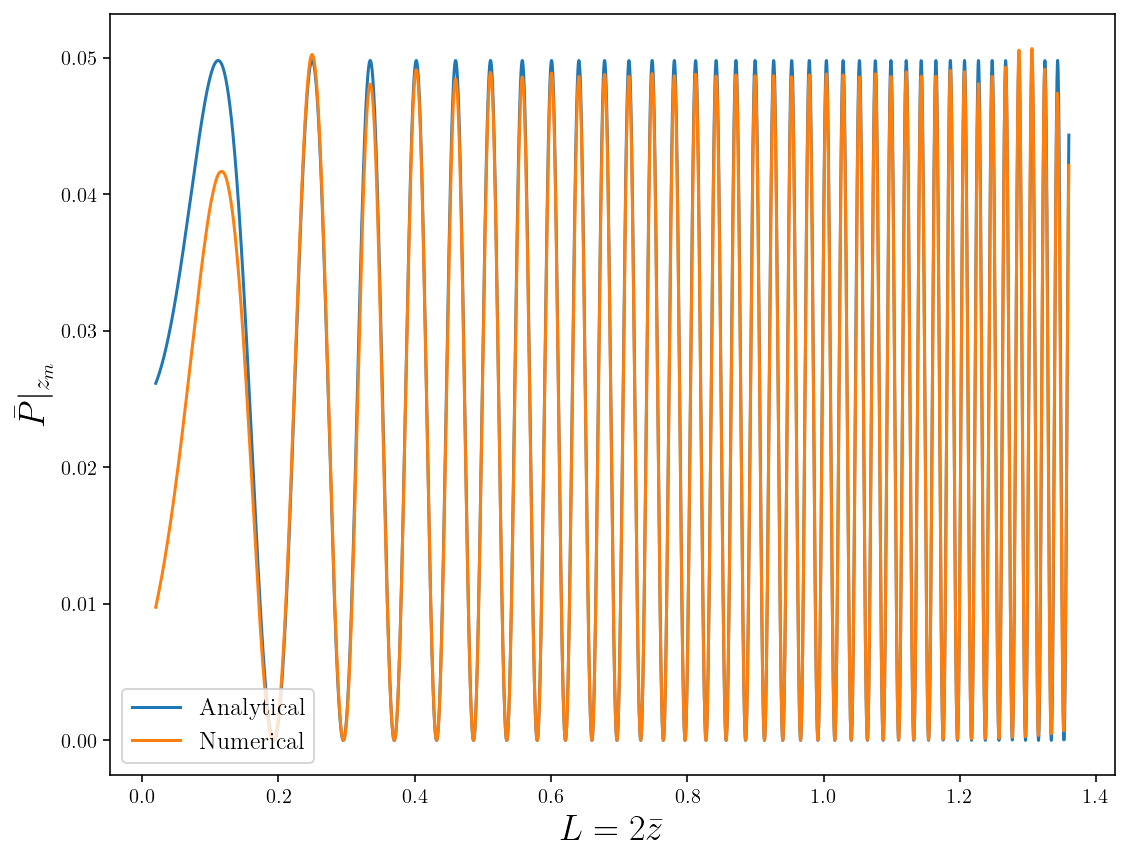

In [26]:
# Numerical vs analytical L = 2z_bar vs Prob. at II resonance curve.

phi_nm_ana = 0.25 * Delta_a(z_barr)/z_0 * (couples3[:,0]) *(couples3[:,0]) /(Delta_ag(z_barr)**2 * Mpc) -np.pi/2
prob_2nd_ana = (2*np.pi)*(gamma_factor[index_z_barr])*(1+1+2*np.cos(phi_nm_ana))

plt.plot(couples3[:,0], prob_2nd_ana, label=r'Analytical')
plt.plot(couples3[:,0], couples3[:,1], label=r'Numerical') 


plt.xlabel(r'$L = 2\bar{z}$', fontsize=18)
plt.ylabel(r'$\bar{P}|_{z_m}$', fontsize=18)
# Set x-axis limits
#plt.xlim(0.3, 0.4)

plt.legend(fontsize=12, loc='lower left')
plt.show()